Importing required dependencies and dataset

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler


transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

num_users = 240

In [2]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = len(train_data)//num_users, shuffle = True)


test_loader = torch.utils.data.DataLoader(test_data, batch_size =  100, shuffle = True)

In [3]:
import syft as sy

hook = sy.TorchHook(torch)

users = []
for i in range(1, num_users+1):
    users.append('user_' + str(i))
    
user_workers = []
for user in users:
    user_workers.append(sy.VirtualWorker(hook, id = user))
    

    



In [4]:
datasets = []
i = 0
for images, labels in train_loader:
    images_ptr = images.send(user_workers[i])
    labels_ptr = labels.send(user_workers[i])
    datasets.append((images_ptr, labels_ptr))
    i += 1

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.Dropout = nn.Dropout(0.01)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.Dropout(F.relu(self.fc1(x)))
        x = self.Dropout(F.relu(self.fc2(x)))
        x = self.Dropout(F.relu(self.fc3(x)))
        x = self.Dropout(F.relu(self.fc4(x)))
        
        x = self.fc5(x)
        
        return x
    
model = Model()
model

Model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (Dropout): Dropout(p=0.01, inplace=False)
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.005)

model.to(device)

epoch_losses = []            
valid_losses = []

for e in range(1, num_epochs+1):
    epoch_loss = 0
    valid_loss = 0
    for images, labels in datasets:
        
        optim.zero_grad()
        
        model.send(images.location)
        
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        #print(labels.shape, pred.shape)
        loss = criterion(logits, labels)
        
        loss.backward()
        optim.step()
        
        model = model.get()
        
        epoch_loss += loss.get().item() * images.shape[0]

        
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        
        valid_loss += loss.item() * images.shape[0]
    
    model.train()
    
    epoch_losses.append(epoch_loss/60000)
    valid_losses.append(valid_loss/10000)
    
    print(f"Epoch: {e}/{num_epochs} Training Loss: {epoch_loss/60000} Validation Loss: {valid_loss/10000}")
        
    


Epoch: 1/50 Training Loss: 2.303291854262352 Validation Loss: 2.301993577480316
Epoch: 2/50 Training Loss: 2.3006940126419066 Validation Loss: 2.2993456649780275
Epoch: 3/50 Training Loss: 2.2980968097845715 Validation Loss: 2.2965877294540404
Epoch: 4/50 Training Loss: 2.2952942579984663 Validation Loss: 2.293506028652191
Epoch: 5/50 Training Loss: 2.292066952586174 Validation Loss: 2.289911694526672
Epoch: 6/50 Training Loss: 2.2881706148386 Validation Loss: 2.285454649925232
Epoch: 7/50 Training Loss: 2.283151517311732 Validation Loss: 2.279499216079712
Epoch: 8/50 Training Loss: 2.2762120296557744 Validation Loss: 2.270987541675568
Epoch: 9/50 Training Loss: 2.2659847845633823 Validation Loss: 2.258159041404724
Epoch: 10/50 Training Loss: 2.2497681866089505 Validation Loss: 2.236858184337616
Epoch: 11/50 Training Loss: 2.2210839380820593 Validation Loss: 2.1969298410415647
Epoch: 12/50 Training Loss: 2.1651906023422876 Validation Loss: 2.118958766460419
Epoch: 13/50 Training Loss: 

Text(0, 0.5, 'Training Loss')

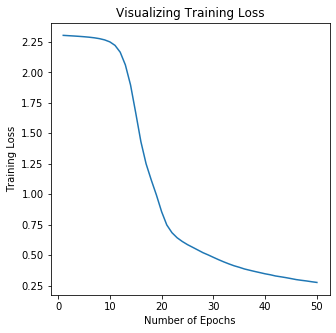

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (5,5))
plt.plot(range(1, num_epochs+1), epoch_losses) 
plt.title("Visualizing Training Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Validation Loss')

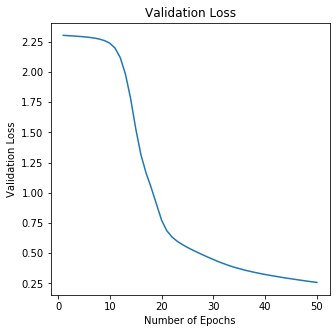

In [9]:
plt.figure(figsize = (5,5))          
plt.plot(range(1, num_epochs+1), valid_losses)
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")

In [10]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

train_on_gpu = True


test_loss = 0.0

class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

model.eval()                                                        


for (images, labels) in test_loader:
    
    images, labels = images.to(device), labels.to(device)
    
    logits = model(images)
    
    loss = criterion(logits, labels)
    
    test_loss += loss.item()*images.size(0)
    
    pred_prob = F.softmax(logits)                               
    
    _, predicted_class = pred_prob.max(1)                       
    
    correct_tensor = predicted_class.eq(labels.data.view_as(predicted_class))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    batch_size = labels.size(0)
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):                                                              
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (                           
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\Users\sachd\Anaconda3\lib\site-packages\syft\frameworks\torch\tensors\interpreters\native.py:397: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)


Test Loss: 1.555749

Test Accuracy of     0: 96% (5732/5923)
Test Accuracy of     1: 96% (6537/6742)
Test Accuracy of     2: 91% (5433/5958)
Test Accuracy of     3: 89% (5515/6131)
Test Accuracy of     4: 93% (5441/5842)
Test Accuracy of     5: 88% (4789/5421)
Test Accuracy of     6: 95% (5664/5918)
Test Accuracy of     7: 94% (5906/6265)
Test Accuracy of     8: 89% (5213/5851)
Test Accuracy of     9: 89% (5301/5949)

Test Accuracy (Overall): 92% (55531/60000)
